# BCQ DDPG 

### Off-Policy Deep Reinforcement Learning without Exploration

I used some code from https://github.com/sfujim/BCQ

Arxiv: https://arxiv.org/abs/1812.02900

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import pickle
import gc
import json
import h5py

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# == recnn ==
import sys
sys.path.append("../../")
import recnn

cuda = torch.device('cuda')

# ---
frame_size = 10
batch_size = 25
# --- 

tqdm.pandas()

In [3]:
# https://drive.google.com/open?id=1kTyu05ZmtP2MA33J5hWdX8OyUYEDW4iI
movie_embeddings_key_dict = pickle.load(open('../../data/infos_pca128.pytorch', 'rb'))
movies_embeddings_tensor, \
key_to_id, id_to_key = recnn.data.make_items_tensor(movie_embeddings_key_dict)
# download ml20m dataset yourself
ratings = pd.read_csv('../../data/ml-20m/ratings.csv')
user_dict, users = recnn.data.prepare_dataset(ratings, key_to_id, frame_size)
del ratings
gc.collect()
clear_output(True)
clear_output(True)
print('Done!')

Done!


In [7]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai')

def run_tests():
    test_batch = next(iter(test_dataloader))
    losses = bcq_update(test_batch, params, learn=False, step=step)
    return losses

def soft_update(net, target_net, soft_tau=1e-2):
    for target_param, param in zip(target_net.parameters(), net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

In [8]:
# Technically, the authors call it variational autoencoder
# But instead of learning to encode/sample state
# It gets state + action as an input
# And generates action
# So it is a stochastic generative model for sampling actions
class Generator(nn.Module):
    def __init__(self, input_dim, action_dim, latent_dim):
        super(Generator, self).__init__()
        #encoder
        self.e1 = nn.Linear(input_dim + action_dim, 750)
        self.e2 = nn.Linear(750, 750)

        self.mean = nn.Linear(750, latent_dim)
        self.log_std = nn.Linear(750, latent_dim)
        
        #decoder
        self.d1 = nn.Linear(input_dim + latent_dim, 750)
        self.d2 = nn.Linear(750, 750)
        self.d3 = nn.Linear(750, action_dim)
        
        self.latent_dim = latent_dim
        self.normal = torch.distributions.Normal(0, 1)


    def forward(self, state, action):
        # z is encoded state + action
        z = F.relu(self.e1(torch.cat([state, action], 1)))
        z = F.relu(self.e2(z))

        mean = self.mean(z)
        # Clamped for numerical stability 
        log_std = self.log_std(z).clamp(-4, 15)
        std = torch.exp(log_std)
        z = mean + std * self.normal.sample(std.size()).to(next(self.parameters()).device)

        # u is decoded action
        u = self.decode(state, z)

        return u, mean, std
    
    def decode(self, state, z=None):
        # When sampling from the VAE, the latent vector is clipped to [-0.5, 0.5]
        if z is None:
            z = self.normal.sample([state.size(0), self.latent_dim])
            z = z.clamp(-0.5, 0.5).to(next(self.parameters()).device)

        a = F.relu(self.d1(torch.cat([state, z], 1)))
        a = F.relu(self.d2(a))
        return self.d3(a)

In [9]:
# P.S. This is not a usual Actor.
# It is a peturbative network that takes an input from the Generator
# And adjusts (perturbates) it to look like normal action
# P.S. Yep, this is also a reference, check out his soundcloud:
# soundcloud.com/perturbator
class Perturbator(nn.Module):
    def __init__(self, input_dim, action_dim, hidden_size, init_w=3e-1):
        super(Perturbator, self).__init__()
        
        self.drop_layer = nn.Dropout(p=0.5)
        
        self.linear1 = nn.Linear(input_dim + action_dim, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, action_dim)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        a = torch.cat([state, action], 1)
        a = F.relu(self.linear1(a))
        a = self.drop_layer(a)
        a = F.relu(self.linear2(a))
        a = self.drop_layer(a)
        a = self.linear3(a) 
        return a + action

In [10]:
def bcq_update(batch, params, learn=True, step=-1):
    
    batch = [i.to(cuda) for i in batch]
    state, action, reward, next_state, done = batch
    reward     = reward.unsqueeze(1)
    done       = done.unsqueeze(1)
    batch_size = done.size(0)
    
    # --------------------------------------------------------#
    # Variational Auto-Encoder Learning
    recon, mean, std = generator_net(state, action)
    recon_loss = F.mse_loss(recon, action)
    KL_loss	= -0.5 * (1 + torch.log(std.pow(2)) - mean.pow(2) - std.pow(2)).mean()
    generator_loss = recon_loss + 0.5 * KL_loss
    
    if not learn:
        debugger.log_object('recon test', recon)
    if learn:
        debugger.log_object('recon', recon)
        debugger.log_error('generator_mean', mean)
        debugger.log_error('generator_std', std)
        
        generator_optimizer.zero_grad()
        generator_loss.backward()
        generator_optimizer.step()
    # --------------------------------------------------------#
    # Value Learning
    with torch.no_grad():
        # p.s. repeat_interleave was added in torch 1.1
        # if an error pops up, run 'conda update pytorch'
        state_rep = torch.repeat_interleave(next_state, params['n_generator_samples'], 0)
        sampled_action = generator_net.decode(state_rep)
        perturbed_action = target_perturbator_net(state_rep, sampled_action)
        target_Q1 = target_value_net1(state_rep, perturbed_action)
        target_Q2 = target_value_net1(state_rep, perturbed_action)
        target_value = 0.75 * torch.min(target_Q1, target_Q2) # value soft update
        target_value+= 0.25 * torch.max(target_Q1, target_Q2) #
        target_value = target_value.view(batch_size, -1).max(1)[0].view(-1, 1)
        
        expected_value = reward + (1.0 - done) * params['gamma'] * target_value

    value = value_net1(state, action)
    value_loss = torch.pow(value - expected_value.detach(), 2).mean()
    debugger.log_error('value', value, test=(not learn))
    debugger.log_error('target_value ', target_value, test=(not learn))
    
    if learn:
        value_optimizer1.zero_grad()
        value_optimizer2.zero_grad()
        value_loss.backward()
        value_optimizer1.step()
        value_optimizer2.step()
    
    # --------------------------------------------------------#
    # Perturbator learning
    sampled_actions = generator_net.decode(state)
    perturbed_actions= perturbator_net(state, sampled_actions)
    perturbator_loss = -value_net1(state, perturbed_actions).mean()
    
    debugger.log_object('sampled_actions', sampled_actions, test=(not learn))
    debugger.log_object('perturbed_actions', perturbed_actions, test=(not learn))
    
    if learn:
        if step % params['perturbator_step']:
            perturbator_optimizer.zero_grad()
            perturbator_loss.backward()
            torch.nn.utils.clip_grad_norm_(perturbator_net.parameters(), -1, 1)
            perturbator_optimizer.step()
        
        soft_update(value_net1, target_value_net1, soft_tau=params['soft_tau'])
        soft_update(value_net2, target_value_net2, soft_tau=params['soft_tau'])
        soft_update(perturbator_net, target_perturbator_net, soft_tau=params['soft_tau'])
        
    # --------------------------------------------------------#

    losses = {'value': value_loss.item(),
              'perturbator': perturbator_loss.item(),
              'generator': generator_loss.item(),
              'step': step}
    
    return losses

In [11]:
# === ddpg settings ===
params = {
    # algorithm parameters
    'gamma'              : 0.99,
    'soft_tau'           : 0.1,
    'n_generator_samples': 10,
    'perturbator_step'   : 30,
    
    # learning rates
    'perturbator_lr' : 1e-5,
    'value_lr'       : 1e-5,
    'generator_lr'   : 1e-3,
}
# === end ===

In [16]:
generator_net = Generator(1290, 128, 512).to(cuda)

value_net1  = recnn.models.Critic(1290, 128, 256).to(cuda)
value_net2  = recnn.models.Critic(1290, 128, 256).to(cuda)
perturbator_net = Perturbator(1290, 128, 256).to(cuda)

target_value_net1 = recnn.models.Critic(1290, 128, 256).to(cuda)
target_value_net2 = recnn.models.Critic(1290, 128, 256).to(cuda)
target_perturbator_net = Perturbator(1290, 128, 256).to(cuda)

target_perturbator_net.eval()
target_value_net1.eval()
target_value_net2.eval()

soft_update(value_net1, target_value_net1, soft_tau=1.0)
soft_update(value_net2, target_value_net2, soft_tau=1.0)
soft_update(perturbator_net, target_perturbator_net, soft_tau=1.0)


# optim.Adam can be replaced with RAdam
value_optimizer1 = optim.Adam(value_net1.parameters(),
                              lr=params['value_lr'], weight_decay=1e-2)
value_optimizer2 = optim.Adam(value_net2.parameters(),
                              lr=params['perturbator_lr'], weight_decay=1e-2)
perturbator_optimizer = optim.Adam(perturbator_net.parameters(),
                              lr=params['value_lr'], weight_decay=1e-2)
generator_optimizer = optim.Adam(generator_net.parameters(), lr=params['generator_lr'])
# I would advice you not to weight decay generator

layout = {
    'train': {'value': [], 'perturbator': [], 'generator': [], 'step': []},
    'test': {'value': [], 'perturbator': [], 'generator': [], 'step': []},
    }

debugger = recnn.Debugger(layout, run_tests)
plotter = recnn.Plotter(debugger, [['generator'], ['value', 'perturbator']],)

In [17]:
value_losses  = []
perturbator_losses = []
generator_losses    = []
test_losses   = [[], [], [], []]

step = 1
n_epochs = 100
batch_size = 25

epoch_bar = tqdm(total=n_epochs)

test_losses = [[], [], [], []]
train_users = users[:-5000]
test_users = users[-5000:]

def prepare_batch_wrapper(x):
    batch = recnn.data.prepare_batch_static_size(x, movies_embeddings_tensor, frame_size=frame_size)
    return batch

train_user_dataset = recnn.data.UserDataset(train_users, user_dict)
test_user_dataset = recnn.data.UserDataset(test_users, user_dict)
train_dataloader = DataLoader(train_user_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=1,collate_fn=prepare_batch_wrapper)
test_dataloader = DataLoader(test_user_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=1,collate_fn=prepare_batch_wrapper)

step 180


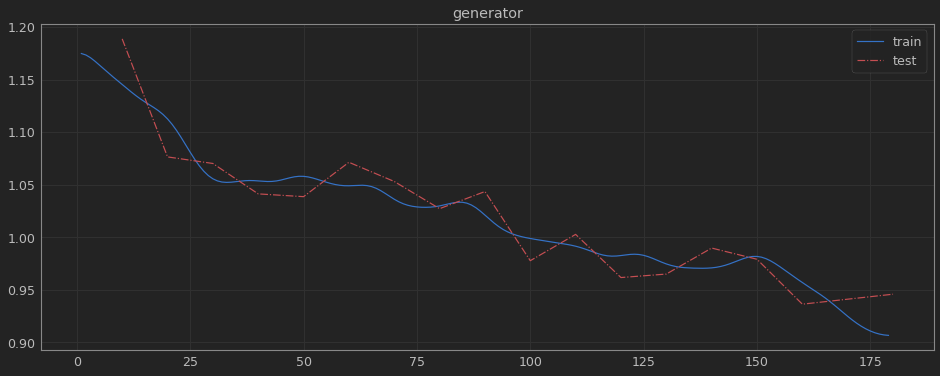

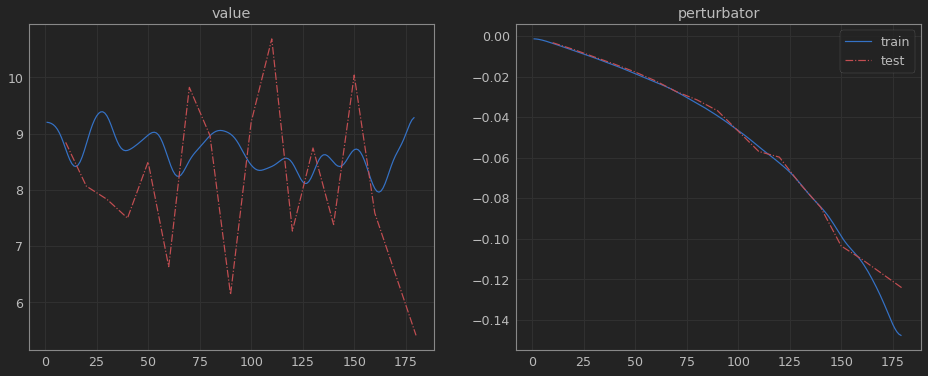

KeyboardInterrupt: 

In [19]:

# --- config ---
plot_every = 10
# --- end ---

for epoch in range(n_epochs):
    epoch_bar.update(1)
    for batch in tqdm(train_dataloader):
        loss = bcq_update(batch, params, step=step)
        debugger.log_losses(loss)
        step += 1
        debugger.log_step(step)
        if step % plot_every == 0:
            clear_output(True)
            print('step', step)
            debugger.test()
            plotter.plot_loss()

In [13]:
#torch.save(generator_net.state_dict(), "../../models/BCQ/bcq_generator.pt")
#torch.save(perturbator_net.state_dict(), "../../models/BCQ/bcq_perturbator.pt")
#torch.save(value_net1.state_dict(), "../../models/BCQ/bcq_value1.pt")
#torch.save(value_net2.state_dict(), "../../models/BCQ/bcq_value2.pt")

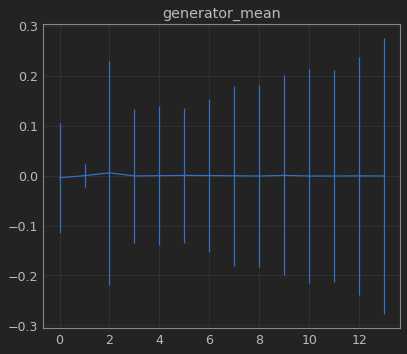

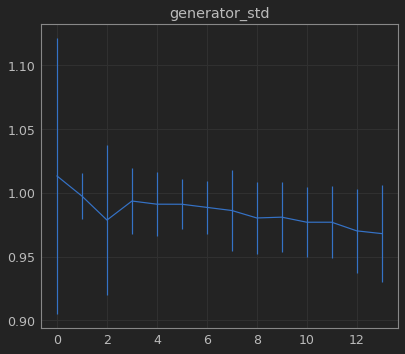

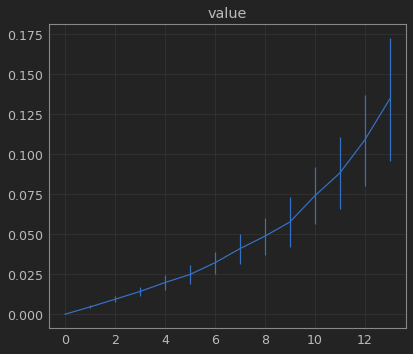

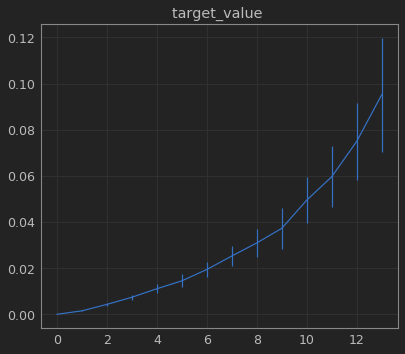

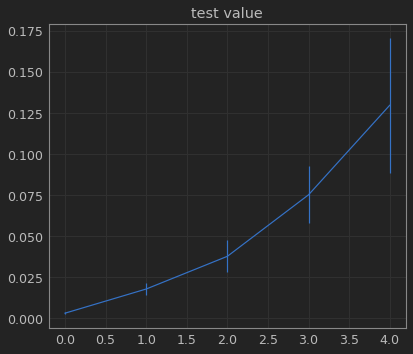

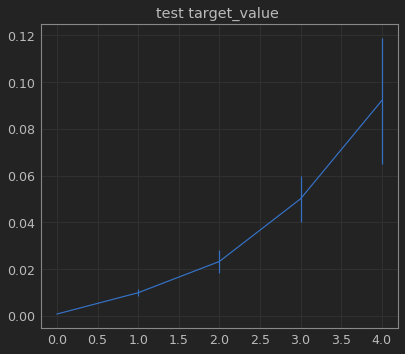

In [20]:
debugger.err_plot()

/home/dev/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


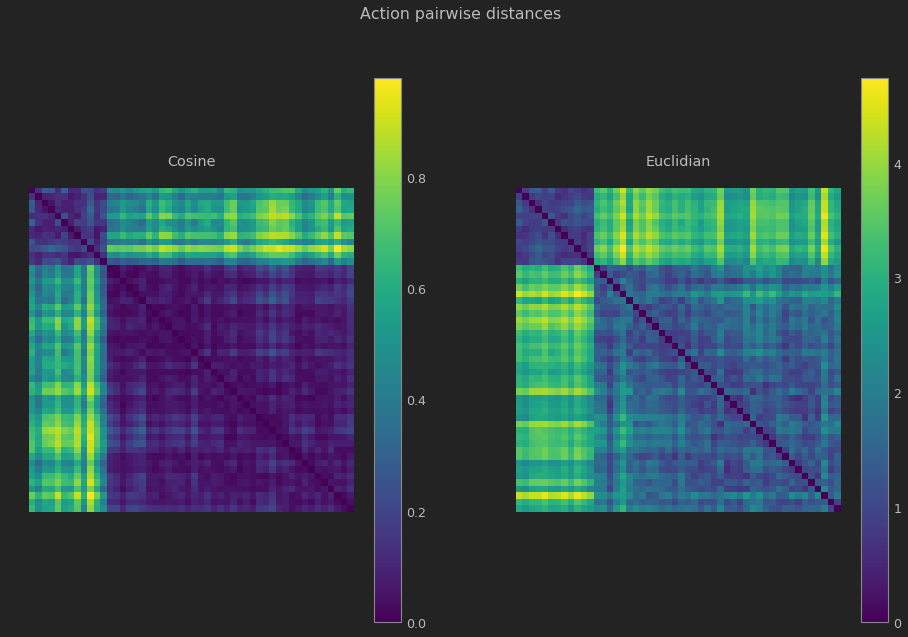

In [21]:
debugger.matshow('test sampled_actions')

/home/dev/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


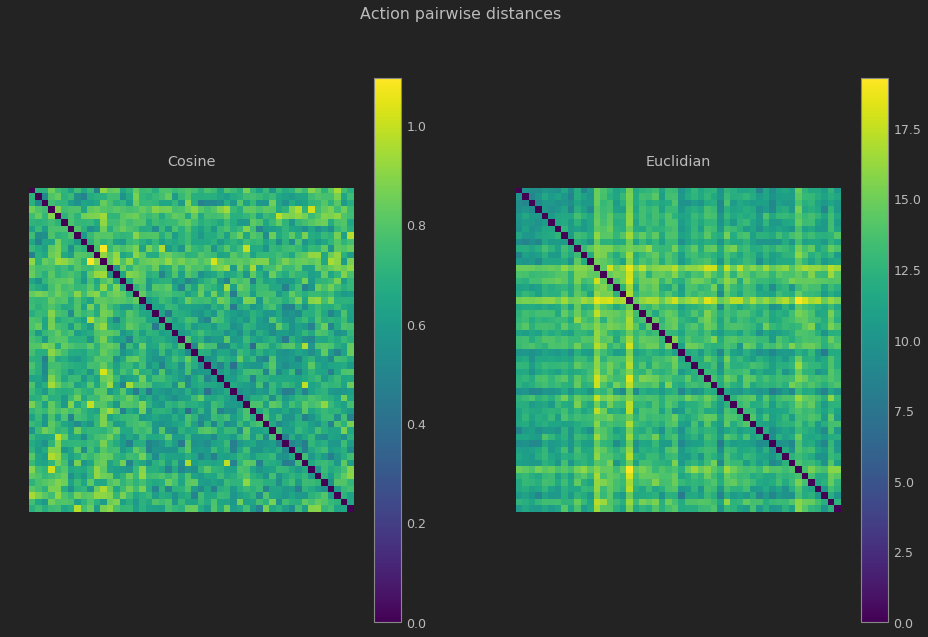

In [22]:
debugger.matshow('test perturbed_actions')

/home/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
../../recnn/debugger.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gen_scores = ad.rec_error(torch.tensor(gen_actions).to(device).float()).detach().cpu().numpy()
../../recnn/debugger.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gen_test_scores = ad.rec_error(torch.tensor(gen_test_actions).to(device).float()).de

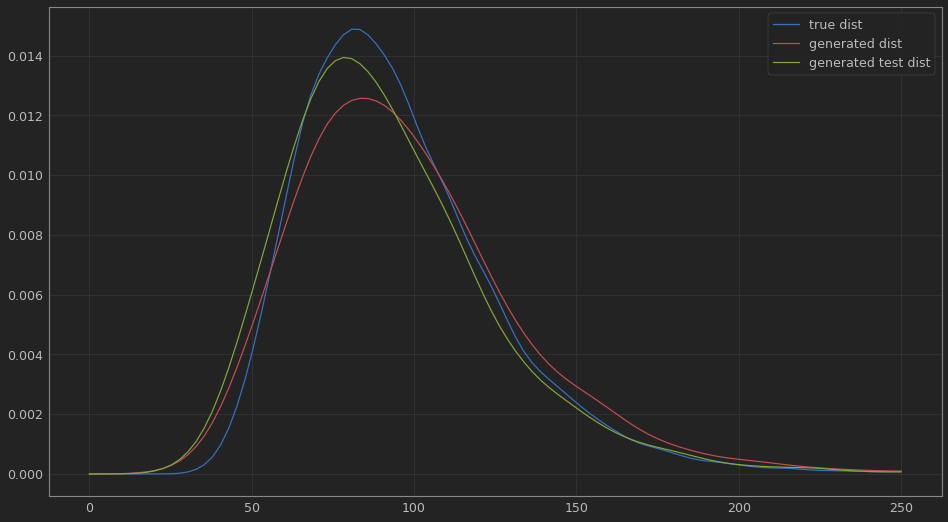

In [23]:
gen_actions = debugger.debug_dict['mat']['perturbed_actions']
gen_test_actions = debugger.debug_dict['mat']['test perturbed_actions']
true_actions = np.stack(movie_embeddings_key_dict.values())


ad = recnn.models.AnomalyDetector().to(cuda)
ad.load_state_dict(torch.load('../../models/anomaly.pt'))
ad.eval()

debugger.plot_kde_reconstruction_error(ad, gen_actions, gen_test_actions, true_actions, cuda)